EfficientNet-B0 with cutmix applied:

Epoch 1/5: 100%|██████████| 225/225 [02:57<00:00,  1.27it/s]


Epoch 1: Train Acc: 54.32%, Val Acc: 96.40%


Epoch 2/5: 100%|██████████| 225/225 [03:05<00:00,  1.22it/s]


Epoch 2: Train Acc: 68.94%, Val Acc: 95.20%


Epoch 3/5: 100%|██████████| 225/225 [03:32<00:00,  1.06it/s]


Epoch 3: Train Acc: 74.29%, Val Acc: 96.40%


Epoch 4/5: 100%|██████████| 225/225 [03:04<00:00,  1.22it/s]


Epoch 4: Train Acc: 73.02%, Val Acc: 96.80%


Epoch 5/5: 100%|██████████| 225/225 [04:19<00:00,  1.15s/it]


Epoch 5: Train Acc: 73.74%, Val Acc: 96.80%


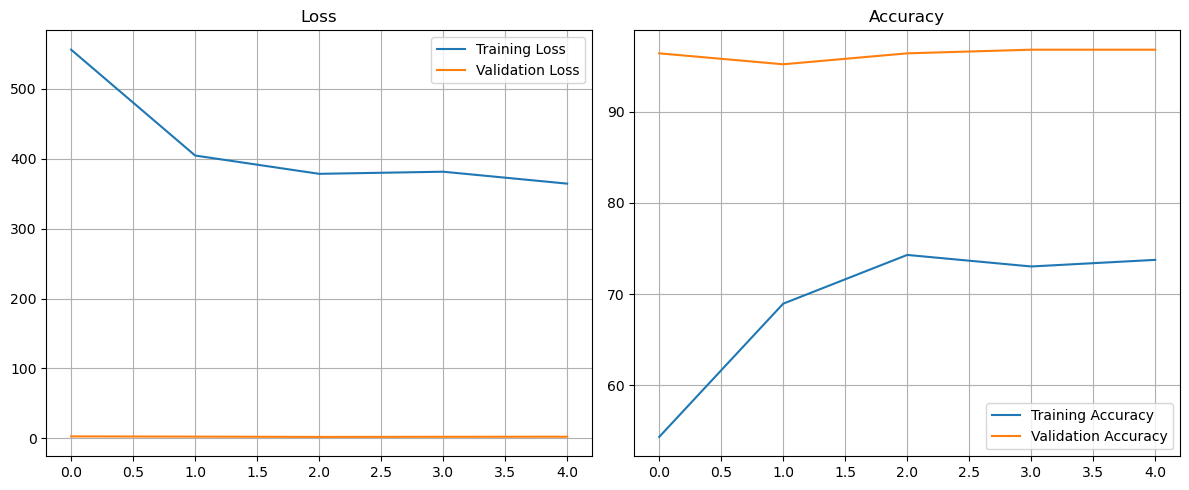

Test Accuracy: 98.80%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.80      0.89         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       0.83      1.00      0.91         5
         EMPEROR

In [68]:
# Import necessary programmes:
from pathlib import Path
import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.transforms.v2 import CutMix  # Add CutMix import

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/kaggle-dataset/archive")

# Transforms - loads default pretrained weights for EfficientNet-B0 (trained on ImageNet)
weights = EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()

# Dictionary-style dataset and dataloader setup
data_transforms = {
    'train': transform,
    'valid': transform,
    'test': transform
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# CutMix setup
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# DataLoaders - only training uses CutMix
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, 
                       num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load EfficientNet-B0 model with pretrained weights
model = efficientnet_b0(weights=weights)
# Retrieve the number of input features to the classifier's final fully connected layer
in_features = model.classifier[1].in_features 
# Replace the final classification layer to match the number of different moth species
model.classifier[1] = nn.Linear(in_features, num_classes)

# Freeze all layers, then unfreeze last block and classifier
for param in model.parameters():
    param.requires_grad = False
# Only unfreeze the very last block
for param in model.features[8].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

model.to(device)

# Loss and optimiser for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # Fixed: For accuracy calculation with soft labels, use argmax for both
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [56]:
torch.save(model.state_dict(), "efficientnet_b0_cutmix_only.pth")

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 50) 
model.load_state_dict(torch.load("efficientnet_b0_cutmix_only.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess the image
image_path = "../data/kaggle-dataset/archive/test/MUSLIN MOTH/1.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0

# Use the same transform as the training code
weights = EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()  

# Apply transform to the original PIL image 
input_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

# Set target layer
target_layer = model.features[-1]

# Initialise Grad-CAM++
cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

# Generate CAM heatmap
grayscale_cam = cam(input_tensor=input_tensor)[0]
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

# Save output
output_path = Path("../cam_outputs/efficientnet_b0_ft/gradcampp-cutmix-muslin-1.jpg")
cv2.imwrite(str(output_path), visualisation)

c:\Users\rebec\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rebec\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


True

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 50) 
model.load_state_dict(torch.load("efficientnet_b0_cutmix_only.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess the image
image_path = "../data/kaggle-dataset/archive/test/BLACK RUSTIC MOTH/4.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0

# Use the same transform as the training code
weights = EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()  

# Apply transform to the original PIL image 
input_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

# Set target layer
target_layer = model.features[-1]

# Initialise Grad-CAM++
cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

# Generate CAM heatmap
grayscale_cam = cam(input_tensor=input_tensor)[0]
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

# Save output
output_path = Path("../cam_outputs/efficientnet_b0_ft/gradcampp-cutmix-black-rustic-4.jpg")
cv2.imwrite(str(output_path), visualisation)

True

We will now apply standard transformations to the efficientnet-b0 model:

Epoch 1/5: 100%|██████████| 225/225 [02:59<00:00,  1.25it/s]


Epoch 1: Train Acc: 50.52%, Val Acc: 93.60%


Epoch 2/5: 100%|██████████| 225/225 [02:44<00:00,  1.37it/s]


Epoch 2: Train Acc: 64.12%, Val Acc: 96.40%


Epoch 3/5: 100%|██████████| 225/225 [02:54<00:00,  1.29it/s]


Epoch 3: Train Acc: 68.58%, Val Acc: 96.80%


Epoch 4/5: 100%|██████████| 225/225 [03:02<00:00,  1.23it/s]


Epoch 4: Train Acc: 68.19%, Val Acc: 95.20%


Epoch 5/5: 100%|██████████| 225/225 [03:05<00:00,  1.21it/s]


Epoch 5: Train Acc: 68.22%, Val Acc: 96.40%


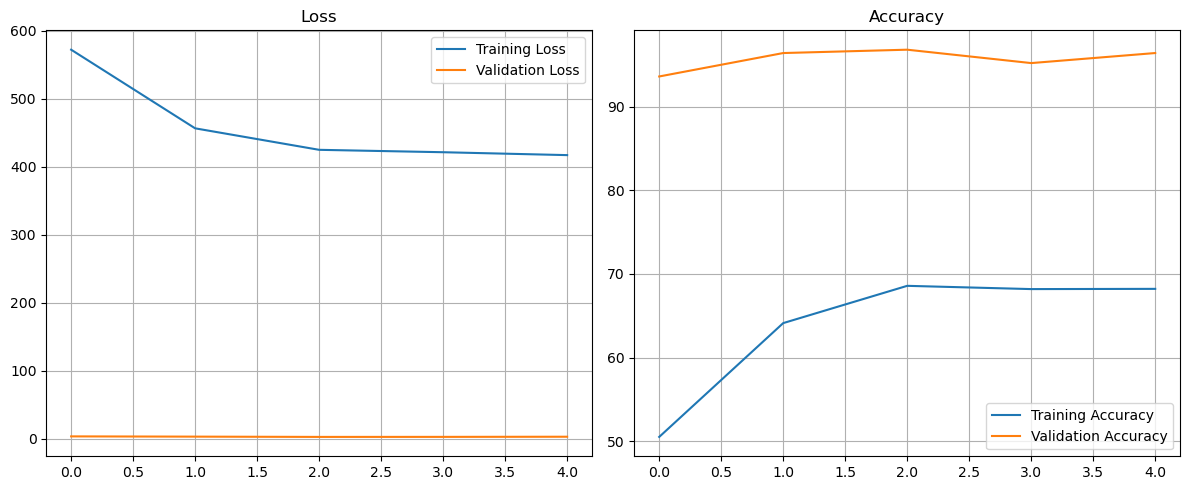

Test Accuracy: 98.00%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      0.80      0.89         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       0.83      1.00      0.91         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.80      0.89         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [69]:
# Import necessary programmes:
from pathlib import Path
import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.transforms.v2 import CutMix

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/kaggle-dataset/archive")

# Transforms with standard augmentations added
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),                      
    transforms.RandomHorizontalFlip(),                  # horizontal flip
    transforms.RandomRotation(15),                      # small rotations
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # lighting variations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)) # Random erasing
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# CutMix setup
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# DataLoaders - only training uses CutMix
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, 
                       num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load EfficientNet-B0 model with pretrained weights
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
# Retrieve the number of input features to the classifier's final fully connected layer
in_features = model.classifier[1].in_features 
# Replace the final classification layer to match the number of different moth species
model.classifier[1] = nn.Linear(in_features, num_classes)

# Freeze all layers, then unfreeze last block and classifier
for param in model.parameters():
    param.requires_grad = False
# Only unfreeze the very last block
for param in model.features[8].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True


model.to(device)

# Loss and optimiser for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [70]:
torch.save(model.state_dict(), "efficientnet_b0_standard_augmentations.pth")

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 50)
model.load_state_dict(torch.load("efficientnet_b0_standard_augmentations.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess image - fiery clearwing moth
image_path = "../data/kaggle-dataset/archive/test/CLEARWING MOTH/1.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

target_layer = model.features[-1]  

cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=input_tensor)[0]  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/efficientnet_b0_ft/gradcampp-standard-augmentations-clearwing-1.jpg")
cv2.imwrite(str(output_path), visualisation)

c:\Users\rebec\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rebec\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


True

In [ ]:
# Directory containing the images
base_path = Path("../cam_outputs/efficientnet_b0_ft") 

# Gather all Score-CAM images for Humming Bird Hawk Moth
image_paths = sorted(base_path.glob("gradcampp-standard-augmentations-clearwing-*.jpg"))

# Display settings
num_images = len(image_paths)
cols = 3
rows = (num_images + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axs for easy indexing
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < num_images:
        img = mpimg.imread(image_paths[i])
        ax.imshow(img)
        ax.set_title(image_paths[i].stem.replace("-", " ").title())
    ax.axis('off')

plt.tight_layout()
plt.show()


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 50)
model.load_state_dict(torch.load("efficientnet_b0_standard_augmentations.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess image - fiery clearwing moth
image_path = "../data/kaggle-dataset/archive/test/HUMMING BIRD HAWK MOTH/1.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Add this
])

input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

target_layer = model.features[-1]  

cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=input_tensor)[0]  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/efficientnet_b0_ft/gradcampp-standard-augmentations-humming-bird-hawk-1.jpg")
cv2.imwrite(str(output_path), visualisation)

True

In [ ]:
# Directory containing the images
base_path = Path("../cam_outputs/efficientnet_b0_ft") 

# Gather all Score-CAM images for Humming Bird Hawk Moth
image_paths = sorted(base_path.glob("gradcampp-standard-augmentations-humming-bird-hawk-*.jpg"))

# Display settings
num_images = len(image_paths)
cols = 3
rows = (num_images + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axs for easy indexing
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < num_images:
        img = mpimg.imread(image_paths[i])
        ax.imshow(img)
        ax.set_title(image_paths[i].stem.replace("-", " ").title())
    ax.axis('off')

plt.tight_layout()
plt.show()

Further transformations will be applied to the commonly confused species pairs:

Epoch 1/5: 100%|██████████| 591/591 [08:00<00:00,  1.23it/s]


Epoch 1: Train Acc: 56.57%, Val Acc: 93.60%


Epoch 2/5: 100%|██████████| 591/591 [07:33<00:00,  1.30it/s]


Epoch 2: Train Acc: 66.45%, Val Acc: 96.00%


Epoch 3/5: 100%|██████████| 591/591 [08:09<00:00,  1.21it/s]


Epoch 3: Train Acc: 70.07%, Val Acc: 96.40%


Epoch 4/5: 100%|██████████| 591/591 [11:17<00:00,  1.15s/it]


Epoch 4: Train Acc: 70.06%, Val Acc: 96.80%


Epoch 5/5: 100%|██████████| 591/591 [09:21<00:00,  1.05it/s]


Epoch 5: Train Acc: 72.40%, Val Acc: 96.80%


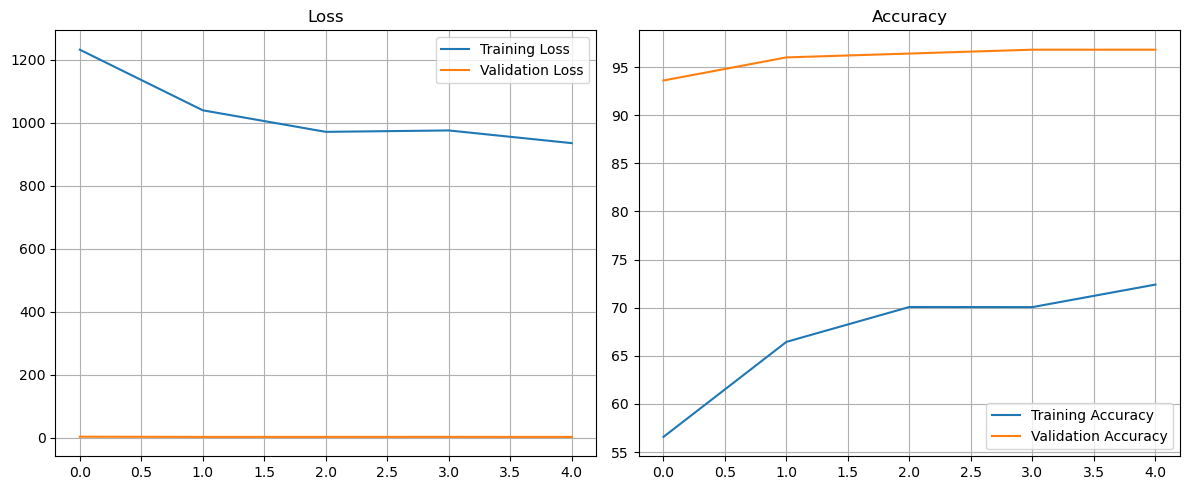

Test Accuracy: 97.60%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      0.60      0.75         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       0.71      1.00      0.83         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      0.80      0.89         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.80      0.89         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      0.80      0.89         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [72]:
# Import necessary programmes:
from pathlib import Path
import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.transforms.v2 import CutMix

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/targeted_augmented_dataset")

# Transforms with standard augmentations added
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),                      
    transforms.RandomHorizontalFlip(),                  # horizontal flip
    transforms.RandomRotation(15),                      # small rotations
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # lighting variations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)) # Random erasing
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# CutMix setup
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# DataLoaders - only training uses CutMix
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, 
                       num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load EfficientNet-B0 model with pretrained weights
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
# Retrieve the number of input features to the classifier's final fully connected layer
in_features = model.classifier[1].in_features 
# Replace the final classification layer to match the number of different moth species
model.classifier[1] = nn.Linear(in_features, num_classes)

# Freeze all layers, then unfreeze last block and classifier
for param in model.parameters():
    param.requires_grad = False
# Only unfreeze the very last block
for param in model.features[8].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True


model.to(device)

# Loss and optimiser for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [73]:
torch.save(model.state_dict(), "efficientnet_b0_final_augmentations.pth")

We will now look at how the targeted augmentations have changed the way the model attends to different parts of the image of each confused species:

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 50)
model.load_state_dict(torch.load("efficientnet_b0_final_augmentations.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess image - fiery clearwing moth
image_path = "../data/kaggle-dataset/archive/test/MUSLIN MOTH/5.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Add this
])

input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

target_layer = model.features[-1]  

cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=input_tensor)[0]  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/efficientnet_b0_ft/gradcampp-final-augmentations-muslin-5.jpg")
cv2.imwrite(str(output_path), visualisation)

True

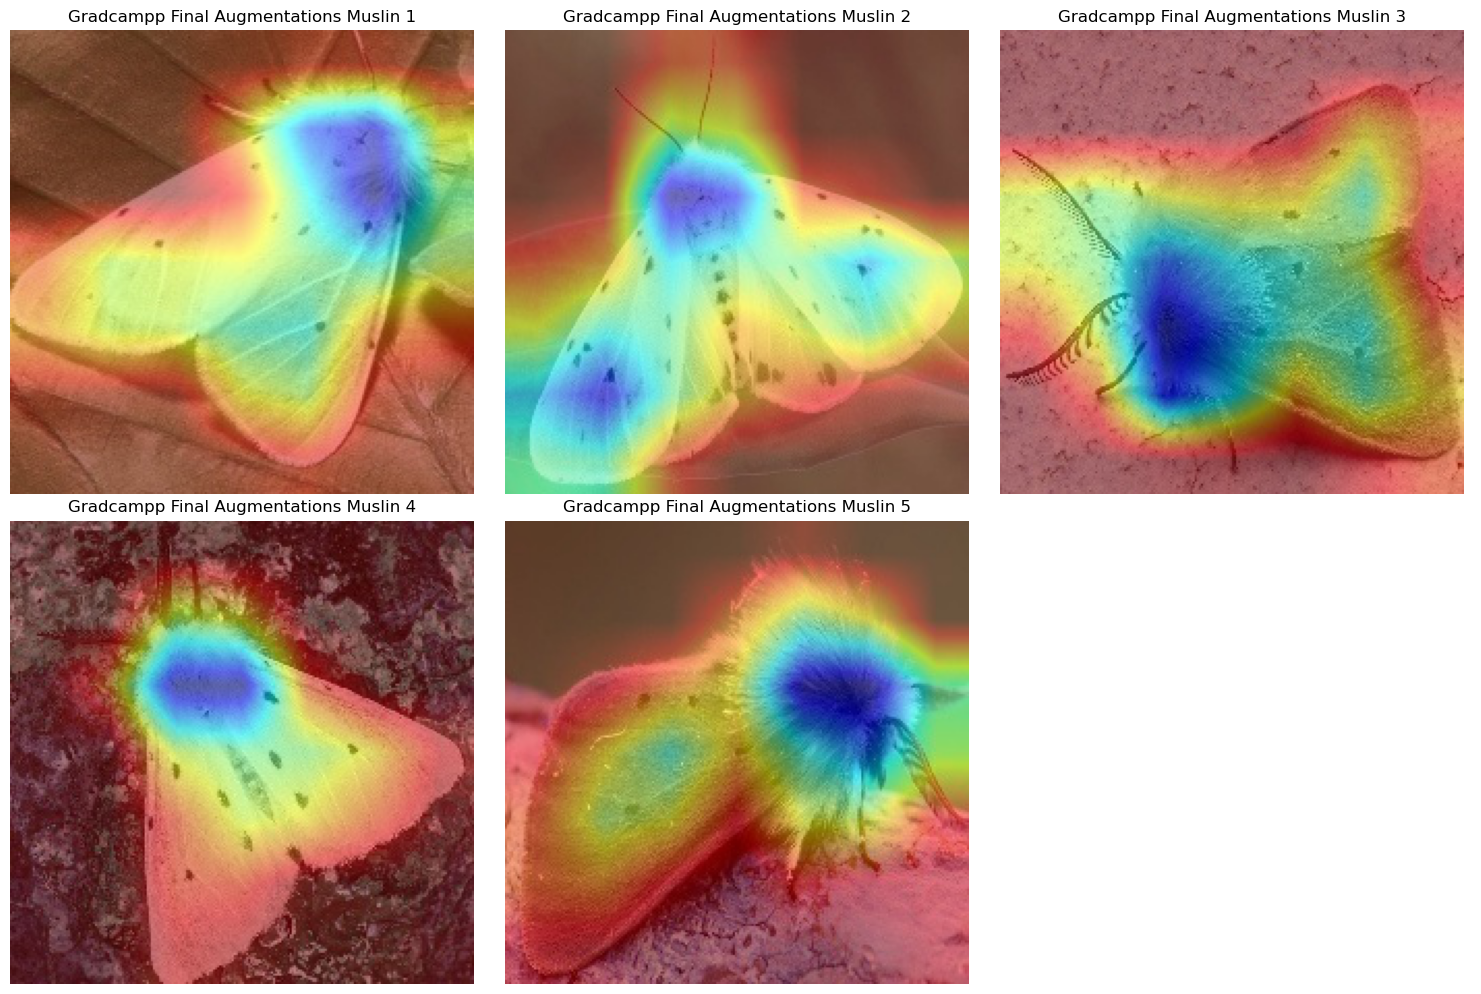

In [81]:
# Directory containing the images
base_path = Path("../cam_outputs/efficientnet_b0_ft") 

# Gather all Score-CAM images for Humming Bird Hawk Moth
image_paths = sorted(base_path.glob("gradcampp-final-augmentations-muslin-*.jpg"))

# Display settings
num_images = len(image_paths)
cols = 3
rows = (num_images + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axs for easy indexing
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < num_images:
        img = mpimg.imread(image_paths[i])
        ax.imshow(img)
        ax.set_title(image_paths[i].stem.replace("-", " ").title())
    ax.axis('off')

plt.tight_layout()
plt.show()


In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 50)
model.load_state_dict(torch.load("efficientnet_b0_final_augmentations.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess image - fiery clearwing moth
image_path = "../data/kaggle-dataset/archive/test/SQUARE SPOT RUSTIC MOTH/5.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Add this
])

input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

target_layer = model.features[-1]  

cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=input_tensor)[0]  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/efficientnet_b0_ft/gradcampp-final-augmentations-square-spot-rustic-5.jpg")
cv2.imwrite(str(output_path), visualisation)

True

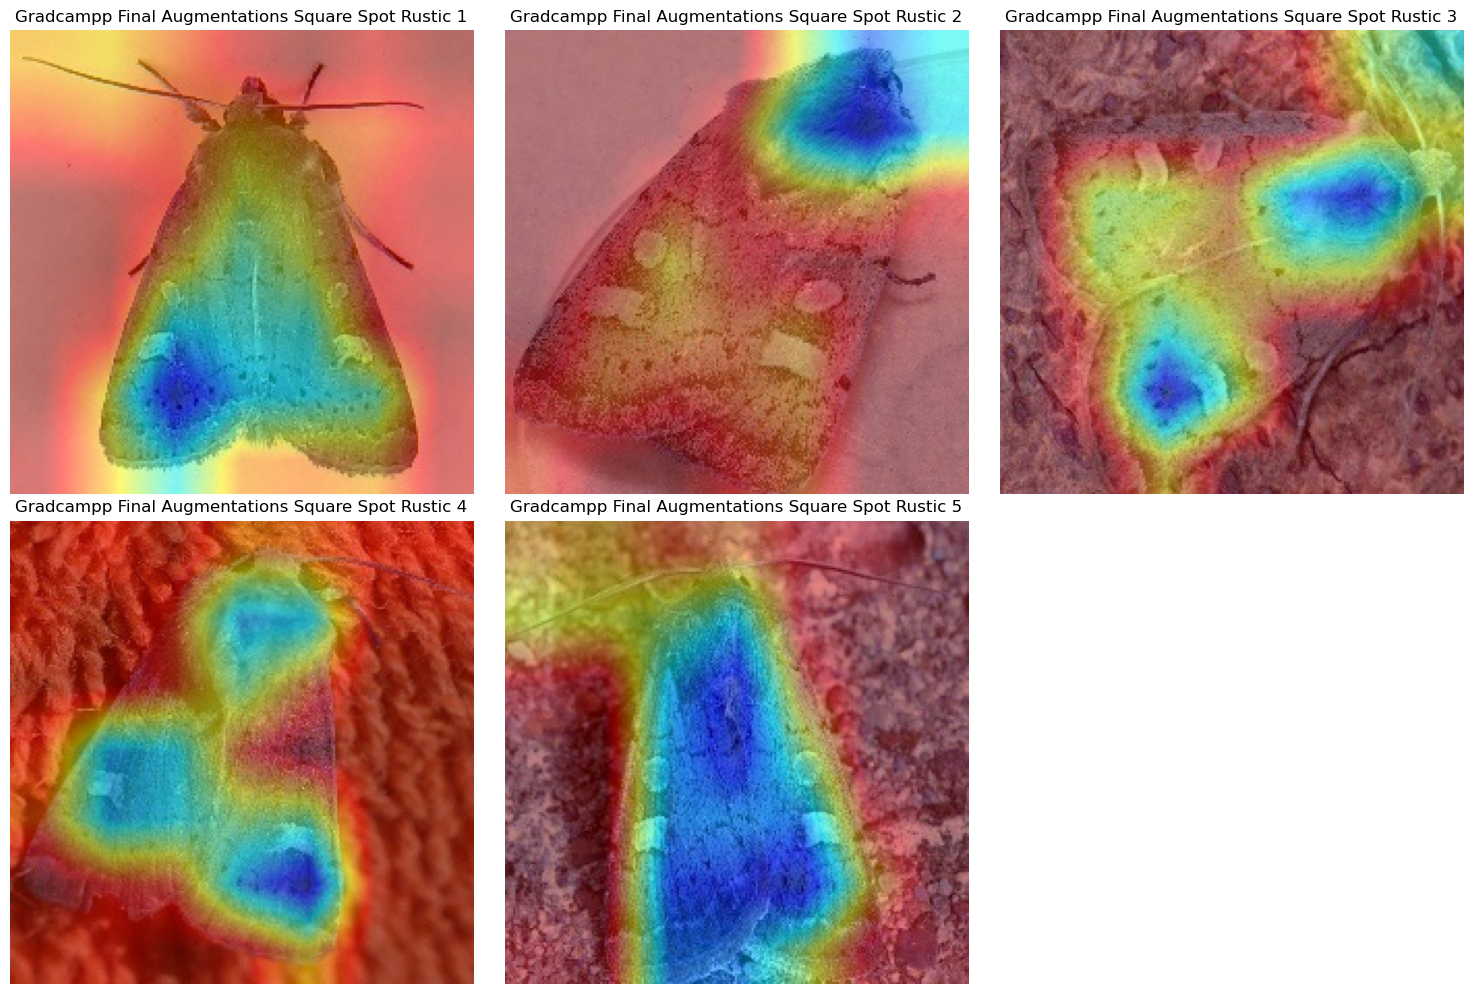

In [87]:
# Directory containing the images
base_path = Path("../cam_outputs/efficientnet_b0_ft") 

# Gather all Score-CAM images for Humming Bird Hawk Moth
image_paths = sorted(base_path.glob("gradcampp-final-augmentations-square-spot-rustic-*.jpg"))

# Display settings
num_images = len(image_paths)
cols = 3
rows = (num_images + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axs for easy indexing
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < num_images:
        img = mpimg.imread(image_paths[i])
        ax.imshow(img)
        ax.set_title(image_paths[i].stem.replace("-", " ").title())
    ax.axis('off')

plt.tight_layout()
plt.show()


For more in-depth fine-tuning, we will unfreeze the last two blocks along with the classifier. We'll also apply layer-wise learning rates and extended training:

Enhanced fine-tuning: 3,350,778/4,071,598 trainable params (82.3%)


Epoch 1/15: 100%|██████████| 591/591 [14:39<00:00,  1.49s/it]


Epoch 1: Train Acc: 67.14%, Val Acc: 97.20%


Epoch 2/15: 100%|██████████| 591/591 [13:43<00:00,  1.39s/it]


Epoch 2: Train Acc: 76.26%, Val Acc: 97.60%


Epoch 3/15: 100%|██████████| 591/591 [14:02<00:00,  1.43s/it]


Epoch 3: Train Acc: 78.96%, Val Acc: 96.80%


Epoch 4/15: 100%|██████████| 591/591 [20:30<00:00,  2.08s/it]


Epoch 4: Train Acc: 78.34%, Val Acc: 97.60%


Epoch 5/15: 100%|██████████| 591/591 [21:20<00:00,  2.17s/it]


Epoch 5: Train Acc: 79.80%, Val Acc: 96.40%


Epoch 6/15: 100%|██████████| 591/591 [17:47<00:00,  1.81s/it]


Epoch 6: Train Acc: 79.27%, Val Acc: 97.60%


Epoch 7/15: 100%|██████████| 591/591 [12:16<00:00,  1.25s/it]


Epoch 7: Train Acc: 80.80%, Val Acc: 96.80%


Epoch 8/15: 100%|██████████| 591/591 [09:26<00:00,  1.04it/s]


Epoch 8: Train Acc: 80.69%, Val Acc: 96.80%


Epoch 9/15: 100%|██████████| 591/591 [10:39<00:00,  1.08s/it]


Epoch 9: Train Acc: 81.66%, Val Acc: 98.00%


Epoch 10/15: 100%|██████████| 591/591 [09:03<00:00,  1.09it/s]


Epoch 10: Train Acc: 80.98%, Val Acc: 96.80%


Epoch 11/15: 100%|██████████| 591/591 [14:32<00:00,  1.48s/it]


Epoch 11: Train Acc: 81.62%, Val Acc: 97.20%


Epoch 12/15: 100%|██████████| 591/591 [09:24<00:00,  1.05it/s]


Epoch 12: Train Acc: 82.36%, Val Acc: 96.80%


Epoch 13/15: 100%|██████████| 591/591 [10:14<00:00,  1.04s/it]


Epoch 13: Train Acc: 81.17%, Val Acc: 97.60%


Epoch 14/15: 100%|██████████| 591/591 [14:03<00:00,  1.43s/it]


Epoch 14: Train Acc: 82.27%, Val Acc: 97.20%


Epoch 15/15: 100%|██████████| 591/591 [10:31<00:00,  1.07s/it]


Epoch 15: Train Acc: 83.14%, Val Acc: 96.80%


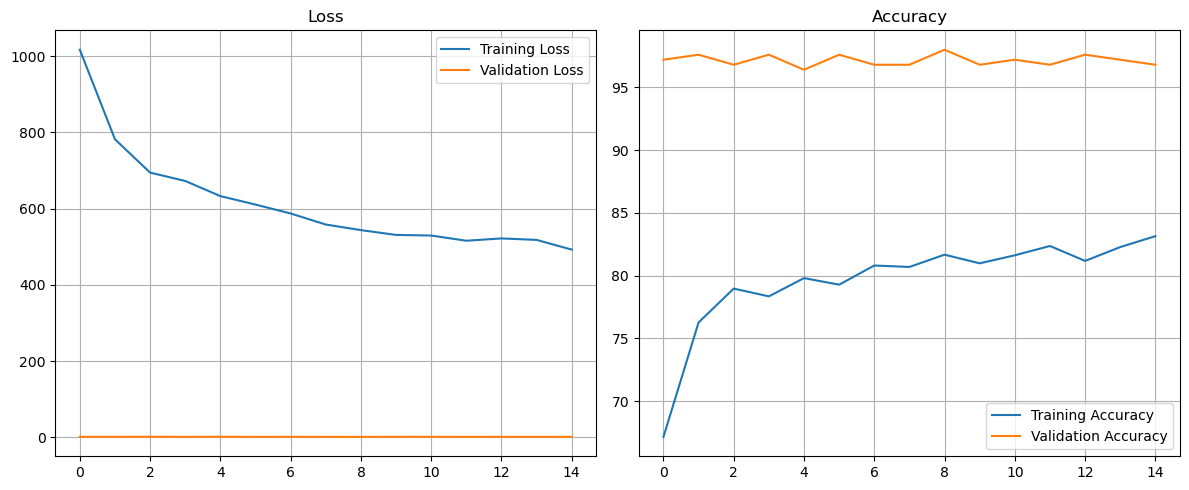

Test Accuracy: 99.60%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       0.83      1.00      0.91         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      1.00      1.00         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image# Import necessary programmes 
from pathlib import Path
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B0_Weights
from torchvision.transforms.v2 import CutMix  

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/targeted_augmented_dataset")

# Enhanced transformations with Random Erasing
weights = EfficientNet_B0_Weights.DEFAULT

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),                      
    transforms.RandomHorizontalFlip(),                                      
    transforms.RandomRotation(15),                                          
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3))
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Dataset and dataloader setup
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Cutmix
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load EfficientNet-B0 model with pretrained weights
model = models.efficientnet_b0(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Deeper unfreezing - unfreeze last 3 feature blocks + classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.features[5].parameters():
    param.requires_grad = True
for param in model.features[6].parameters():
    param.requires_grad = True
for param in model.features[7].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

model.to(device)

# Discriminative learning rates setup
base_lr = 1e-3
param_groups = [
    {'params': model.features[5].parameters(), 'lr': base_lr * 0.1},  # Conservative
    {'params': model.features[6].parameters(), 'lr': base_lr * 0.5},  # Moderate  
    {'params': model.features[7].parameters(), 'lr': base_lr * 0.8},  # Aggressive
    {'params': model.classifier.parameters(), 'lr': base_lr}          # Most aggressive
]

optimizer = optim.Adam(param_groups, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=7, gamma=0.5)

# Count trainable parameters for reference
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Enhanced fine-tuning: {trainable_params:,}/{total_params:,} trainable params ({100*trainable_params/total_params:.1f}%)")

# Loss and optimiser
criterion = nn.CrossEntropyLoss()

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 15

for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")
    
    # Step the scheduler
    scheduler.step()

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [67]:
torch.save(model.state_dict(), "efficientnet_b0_final_finetuning.pth")

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 50)
model.load_state_dict(torch.load("efficientnet_b0_final_finetuning.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess image - fiery clearwing moth
image_path = "../data/kaggle-dataset/archive/test/CLEARWING MOTH/1.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Add this
])

input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

target_layer = model.features[-1]  

cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=input_tensor)[0]  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/efficientnet_b0_ft/gradcampp-final-finetuning-clearwing-1.jpg")
cv2.imwrite(str(output_path), visualisation)

True

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 50)
model.load_state_dict(torch.load("efficientnet_b0_final_finetuning.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess image - fiery clearwing moth
image_path = "../data/kaggle-dataset/archive/test/HUMMING BIRD HAWK MOTH/1.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Add this
])

input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

target_layer = model.features[-1]  

cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=input_tensor)[0]  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/efficientnet_b0_ft/gradcampp-final-finetuning-humming-bird-hawk-1.jpg")
cv2.imwrite(str(output_path), visualisation)

True

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 50)
model.load_state_dict(torch.load("efficientnet_b0_final_finetuning.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess image - fiery clearwing moth
image_path = "../data/kaggle-dataset/archive/test/BLACK RUSTIC MOTH/1.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Add this
])

input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

target_layer = model.features[-1]  

cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=input_tensor)[0]  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/efficientnet_b0_ft/gradcampp-final-finetuning-black-rustic-1.jpg")
cv2.imwrite(str(output_path), visualisation)

True

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 50)
model.load_state_dict(torch.load("efficientnet_b0_final_finetuning.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess image - fiery clearwing moth
image_path = "../data/kaggle-dataset/archive/test/MUSLIN MOTH/1.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Add this
])

input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

target_layer = model.features[-1]  

cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=input_tensor)[0]  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/efficientnet_b0_ft/gradcampp-final-finetuning-muslin-1.jpg")
cv2.imwrite(str(output_path), visualisation)

True

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 50)
model.load_state_dict(torch.load("efficientnet_b0_final_finetuning.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess image - fiery clearwing moth
image_path = "../data/kaggle-dataset/archive/test/BIRD CHERRY ERMINE MOTH/1.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Add this
])

input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

target_layer = model.features[-1]  

cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=input_tensor)[0]  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/efficientnet_b0_ft/gradcampp-final-finetuning-bird-cherry-ermine-1.jpg")
cv2.imwrite(str(output_path), visualisation)

True

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 50)
model.load_state_dict(torch.load("efficientnet_b0_final_finetuning.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess image - fiery clearwing moth
image_path = "../data/kaggle-dataset/archive/test/SQUARE SPOT RUSTIC MOTH/1.jpg"
rgb_img = np.array(Image.open(image_path).convert("RGB")) / 255.0 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Add this
])

input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

target_layer = model.features[-1]  

cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=input_tensor)[0]  
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/efficientnet_b0_ft/gradcampp-final-finetuning-square-spot-rustic-1.jpg")
cv2.imwrite(str(output_path), visualisation)

True

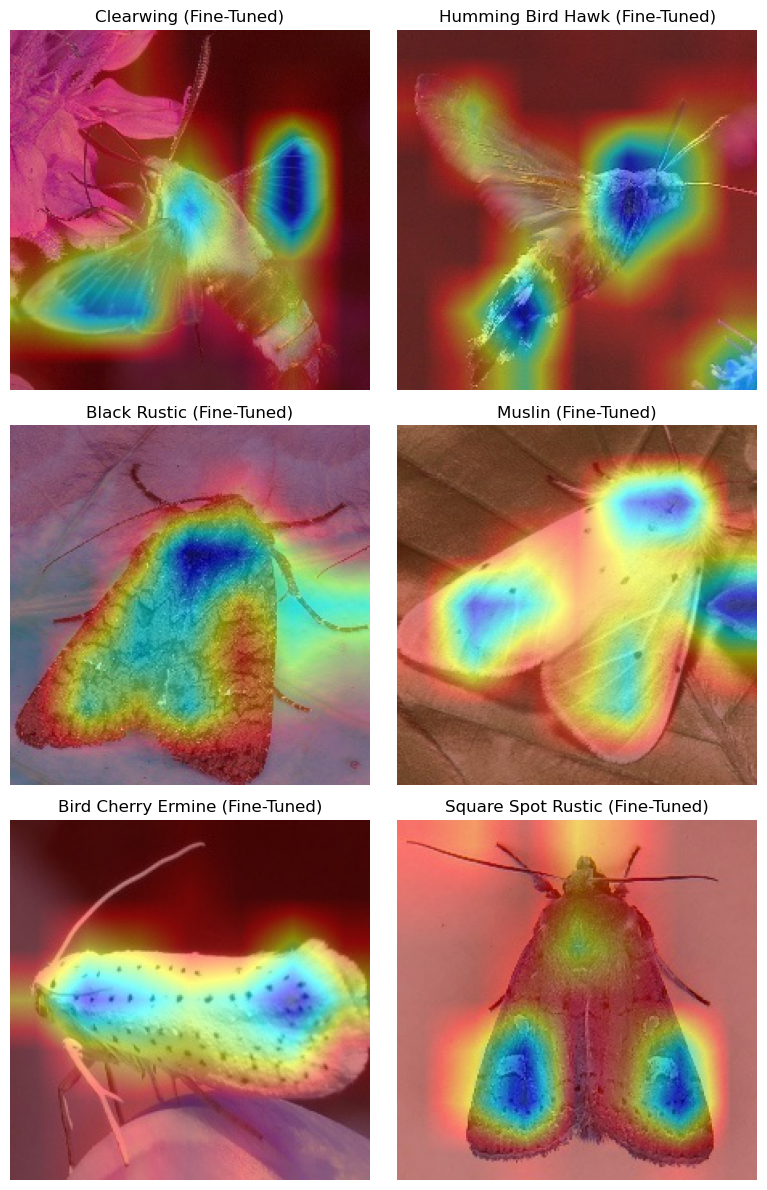

In [95]:
# Define species pairs (based on original confusion)
species_pairs = [
    ("clearwing", "humming-bird-hawk"),
    ("black-rustic", "muslin"),
    ("bird-cherry-ermine", "square-spot-rustic"),
]

# Set the base directory for fine-tuned Grad-CAM++ outputs
base_path = Path("../cam_outputs/efficientnet_b0_ft")

# Set up plot
fig, axs = plt.subplots(len(species_pairs), 2, figsize=(8, len(species_pairs) * 4))

# Loop through each pair and display the first fine-tuned CAM image for each
for i, (sp1, sp2) in enumerate(species_pairs):
    img1 = mpimg.imread(base_path / f"gradcampp-final-finetuning-{sp1}-1.jpg")
    img2 = mpimg.imread(base_path / f"gradcampp-final-finetuning-{sp2}-1.jpg")

    axs[i, 0].imshow(img1)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"{sp1.replace('-', ' ').title()} (Fine-Tuned)")

    axs[i, 1].imshow(img2)
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f"{sp2.replace('-', ' ').title()} (Fine-Tuned)")

plt.tight_layout()
plt.show()
